In [1]:
# Import necessary libraries 

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# connect to sql

In [3]:
import getpass
password = getpass.getpass()

········


In [4]:
connection_string = "mysql+pymysql://root:" + password + '@localhost/bank'
engine = create_engine(connection_string)

query = """
SELECT 
    t.type,
    t.operation,
    t.amount AS t_amount,
    t.balance,
    t.k_symbol,
    l.amount AS l_amount,
    l.duration,
    l.payments,
    l.status
FROM
    trans t
        LEFT JOIN
    loan l ON t.account_id = l.account_id
    where l.status in ('A', 'B');
"""

In [5]:
data = pd.read_sql_query(query, engine)

In [6]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A


### EDA - get to know the data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74364 entries, 0 to 74363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       74364 non-null  object 
 1   operation  74364 non-null  object 
 2   t_amount   74364 non-null  float64
 3   balance    74364 non-null  float64
 4   k_symbol   74364 non-null  object 
 5   l_amount   74364 non-null  int64  
 6   duration   74364 non-null  int64  
 7   payments   74364 non-null  float64
 8   status     74364 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 5.1+ MB


In [8]:
# see means, avg etc 
data.describe()

,t_amount,balance,l_amount,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


In [9]:
# check data types

data.dtypes 

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration       int64
payments     float64
status        object
dtype: object

In [10]:
data.shape

(74364, 9)

In [11]:
# check for nulls 
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [12]:
# change duration column into categorical / object, becaus it has different values ( years: 1,2,3,4,5)
data['duration'] = data['duration'].astype('object')

In [13]:
# filter all the NaN values 
data = data[~data['duration'].isna()]

In [14]:
# check them again 
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74364 entries, 0 to 74363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       74364 non-null  object 
 1   operation  74364 non-null  object 
 2   t_amount   74364 non-null  float64
 3   balance    74364 non-null  float64
 4   k_symbol   74364 non-null  object 
 5   l_amount   74364 non-null  int64  
 6   duration   74364 non-null  object 
 7   payments   74364 non-null  float64
 8   status     74364 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 5.7+ MB


### Cleaning / Wrangling Categoricals Values 

In [16]:
# check values for 'opearation' column 

data['operation'].value_counts()

VYBER             34667
                  14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64

In [17]:
# replace 'empty' row with 'unknown'

def clean_operation(x):
    x = x.lower()
    if 'vyber' in x:
        return 'vyber'
    elif 'prevod' in x:
        return 'prevod'
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

In [18]:
data['operation'] = data['operation'].apply(clean_operation)

In [19]:
data['operation'].value_counts()

vyber      35057
unknown    14646
prevod     14136
vklad      10525
Name: operation, dtype: int64

In [20]:
# apply the same for 'k_symbol' column. it includes ' ' white spaces 
data['k_symbol'].value_counts()

               35953
UROK           14646
SLUZBY         11306
SIPO            5081
                3018
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

In [21]:
def clean_ksymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

In [22]:
data['k_symbol'].value_counts().index

Index(['', 'UROK', 'SLUZBY', 'SIPO', ' ', 'UVER', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [23]:
data['k_symbol'] = data['k_symbol'].apply(clean_ksymbol)

In [24]:
data['k_symbol'].value_counts()

unknown        38971
UROK           14646
SLUZBY         11306
SIPO            5081
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

In [25]:
# filter the column again to get rid off 'POJISTINE', 'SANKC. UROK' or 'UVER'
data = data[~data['k_symbol'].isin(['POJISTINE', 'SANKC. UROK', 'UVER'])]

In [26]:
data['type'].value_counts()

VYDAJ     40874
PRIJEM    27660
VYBER      2629
Name: type, dtype: int64

### check correlations for numerical columns

In [27]:
# check for multicollinearity 
corr_matrix = data.corr()

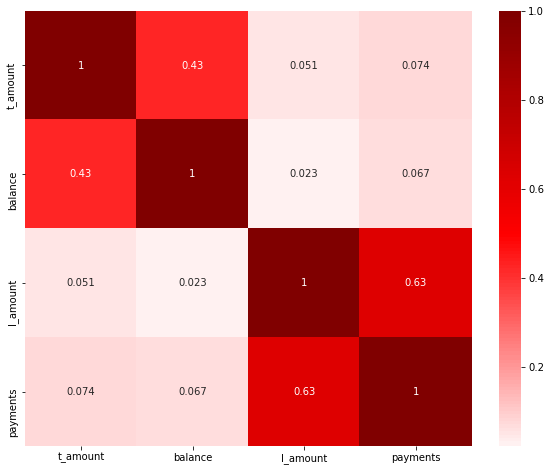

In [28]:
# you can modify sizes, colour etc by simply editing them 

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix,
           cmap='seismic',
           center=0,
           annot=True,
           );

In [29]:
# some high correlations between values: Come back after first model validation and maybe drop highly correlated features

In [30]:
# For colors names, check out: https://matplotlib.org/stable/gallery/color/colormap_reference.html

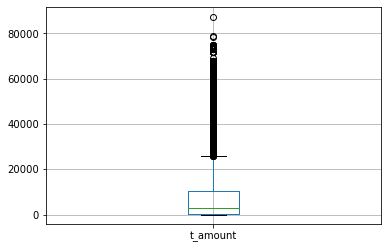

In [31]:
data[['t_amount']].boxplot()
plt.show()

In [32]:
data['t_amount'].describe()

count    71163.000000
mean      8012.117481
std      11948.052672
min          0.100000
25%        137.600000
50%       2837.000000
75%      10500.000000
max      87300.000000
Name: t_amount, dtype: float64

Frequency analysis of column:  type
Frequency analysis of column:  operation
Frequency analysis of column:  k_symbol
Frequency analysis of column:  duration
Frequency analysis of column:  status


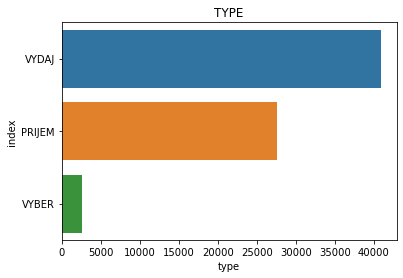

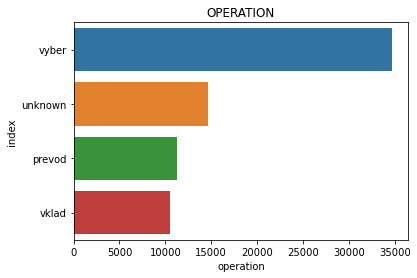

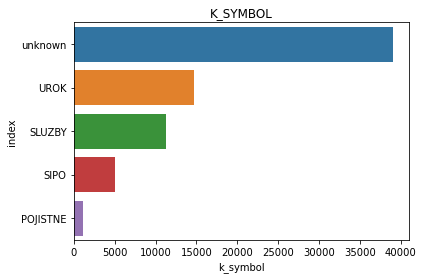

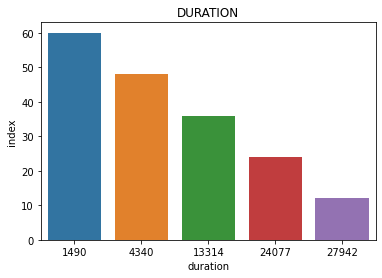

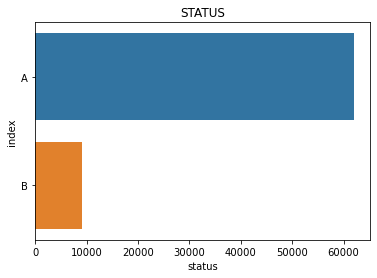

<Figure size 432x288 with 0 Axes>

In [33]:
## check all the categorical columns
cols_cat = list(data.select_dtypes(include=['object']).columns)

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print

### Pre- processing

In [34]:
# label / encode any categorical columns 

In [35]:
cat = data.select_dtypes(include = np.object)
cat

,type,operation,k_symbol,duration,status
0,PRIJEM,prevod,unknown,24,A
1,PRIJEM,vklad,unknown,12,A
2,PRIJEM,vklad,unknown,36,A
3,PRIJEM,vklad,unknown,12,A
4,PRIJEM,vklad,unknown,12,A
...,...,...,...,...,...
74359,PRIJEM,unknown,UROK,36,A
74360,PRIJEM,unknown,UROK,24,B
74361,PRIJEM,unknown,UROK,36,A
74362,PRIJEM,unknown,UROK,60,A


In [36]:
cat = pd.get_dummies(cat,
               drop_first=True,
               columns=['type', 'operation', 'k_symbol', 'duration', 'status'])

In [37]:
cat.head()

,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unknown,duration_24,duration_36,duration_48,duration_60,status_B
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [38]:
# Numerical Scaling 

In [40]:
from sklearn.preprocessing import Normalizer

X = data.select_dtypes(include = np.number)

In [41]:
X.head()

,t_amount,balance,l_amount,payments
0,44749.0,45549.0,79608,3317.0
1,1000.0,1000.0,52788,4399.0
2,1100.0,1100.0,21924,609.0
3,700.0,700.0,23052,1921.0
4,900.0,900.0,41904,3492.0


In [42]:
transformer = Normalizer()
transformer.fit(X)
X_normalized = transformer.transform(X)

In [43]:
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

### Drop the dependant variable (define y) 

In [44]:
y= cat['status_B']
cat=cat.drop(['status_B'], axis=1)
cat

,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unknown,duration_24,duration_36,duration_48,duration_60
0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,1,0,0
3,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74359,0,0,1,0,0,0,0,1,0,0,1,0,0
74360,0,0,1,0,0,0,0,1,0,1,0,0,0
74361,0,0,1,0,0,0,0,1,0,0,1,0,0
74362,0,0,1,0,0,0,0,1,0,0,0,0,1


In [45]:
# bring the numerical data (scaled)in with the categorical
X = np.concatenate((X_normalized, cat),axis=1)

In [48]:
X

array([[0.43826055, 0.44609555, 0.7796609 , ..., 0.        , 0.        ,
        0.        ],
       [0.01887154, 0.01887154, 0.99619079, ..., 0.        , 0.        ,
        0.        ],
       [0.0500283 , 0.0500283 , 0.99710942, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.00123774, 0.28201368, 0.95903966, ..., 1.        , 0.        ,
        0.        ],
       [0.00101855, 0.29594122, 0.95507297, ..., 0.        , 0.        ,
        1.        ],
       [0.00219882, 0.53770647, 0.84239831, ..., 0.        , 0.        ,
        0.        ]])

# Test-Train Split and Modelling

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size= 0.4, random_state=40)

## Apply and train model 

In [51]:
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400,
                  multi_class='ovr').fit(X_train, y_train)

### Evaluate accuracy and Test 

In [52]:
from sklearn.metrics import accuracy_score 
predictions = classification.predict(X_test)

In [53]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [54]:
accuracy_score(y_test, predictions)

0.8788379118948921

### Evaluating the Model

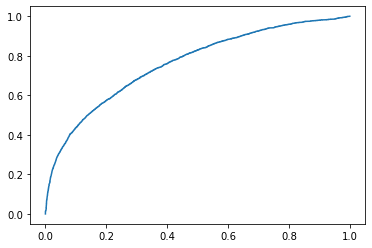

In [61]:
# ROC curve
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_proba = classification.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)



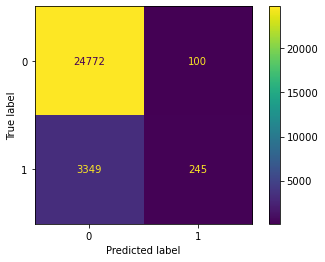

In [60]:
# The Confusion Matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

accuracy_score(y_test, predictions)
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()